We’ll build a federated learning system using the Flower framework, Flower Datasets and PyTorch.

*   In part 1, we will use *Pytorch for model training pipeine and data loading*.
*   In part 2, we will form the Pytorch project using Flower.



**Step 0: Preparation**

---



Install dependencies

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr_datasets import FederatedDataset

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.17.0 / PyTorch 2.6.0+cu124


Load the data





1.   We're using Federated Learning by training CNN on CIFAR-10 dataset.
2.   Each organization will act as a client in the federated learning system.
3.   We're using the Flower Datasets library *(flwr-datasets)* to partition *CIFAR-10* using FederatedDataset. We'll create train and test set for each organization and give them to *PyTorch DataLoader*.



In [ ]:
NUM_CLIENTS=10
fds=FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
fds

In [ ]:
fds.partitioners

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

{'train': <flwr_datasets.partitioner.iid_partitioner.IidPartitioner at 0x7800caeea5d0>}

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

In [ ]:
total_train = fds.load_split("train")
print(len(total_train))
total_test = fds.load_split("test")
print(len(total_test))

50000
10000


In [ ]:
fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
partition = fds.load_partition(1)
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

def apply_transforms(batch):
    batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
    return batch

trainloader = DataLoader(
    partition_train_test["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    partition_train_test["test"], batch_size=BATCH_SIZE
)

testset = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(
    testset, batch_size=BATCH_SIZE
)
print(trainloader)  # Print DataLoader object reference
print(valloader)
print(testloader)

In [ ]:
print(len(partition))
print(len(partition_train_test["train"]))
print(len(partition_train_test["test"]))

5000
4000
1000


In [ ]:
fds.load_partition(1)

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

pytorch_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL.Image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def apply_transforms(batch):
    batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
    return batch

partition_train_test = partition_train_test.with_transform(apply_transforms)

BATCH_SIZE = 32
trainloader = DataLoader(
    partition_train_test["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    partition_train_test["test"],
    batch_size=BATCH_SIZE
)
testset = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE
)

for batch in trainloader:
    print(batch)
    break

{'img': tensor([[[[-0.5216, -0.5216, -0.5294,  ..., -0.5529, -0.5608, -0.5765],
          [-0.5216, -0.5294, -0.5373,  ..., -0.5608, -0.5608, -0.5765],
          [-0.4980, -0.5059, -0.5294,  ..., -0.5529, -0.5686, -0.5922],
          ...,
          [-0.5373, -0.5765, -0.5765,  ..., -0.6784, -0.6863, -0.6863],
          [-0.5843, -0.6235, -0.6235,  ..., -0.6549, -0.6549, -0.6471],
          [-0.6000, -0.6157, -0.6157,  ..., -0.6235, -0.6157, -0.6157]],

         [[-0.3490, -0.3490, -0.3569,  ..., -0.4196, -0.4353, -0.4588],
          [-0.3647, -0.3725, -0.3882,  ..., -0.4118, -0.4275, -0.4510],
          [-0.3647, -0.3725, -0.3961,  ..., -0.3961, -0.4196, -0.4510],
          ...,
          [-0.4353, -0.4118, -0.4275,  ..., -0.5529, -0.5529, -0.5608],
          [-0.4745, -0.4588, -0.4667,  ..., -0.5216, -0.5137, -0.5216],
          [-0.4902, -0.4745, -0.4980,  ..., -0.4902, -0.4824, -0.4824]],

         [[-0.6314, -0.6235, -0.6157,  ..., -0.6706, -0.6706, -0.6706],
          [-0.6471, -0

In [ ]:
for batch in trainloader:
  print(batch['img'][0])
  print(batch['img'][0].shape)
  print(batch['label'][0])
  break

tensor([[[-0.5059, -0.4980, -0.2157,  ..., -0.2235, -0.2627, -0.1137],
         [-0.4588, -0.4039, -0.1765,  ..., -0.2314, -0.3412, -0.2000],
         [-0.4588, -0.4039, -0.2392,  ..., -0.2627, -0.3255, -0.0902],
         ...,
         [ 0.5922,  0.5529,  0.2706,  ...,  0.4353,  0.4275,  0.4824],
         [ 0.6627,  0.6235,  0.4902,  ...,  0.4431,  0.4667,  0.4902],
         [ 0.7176,  0.6863,  0.6706,  ...,  0.6000,  0.6078,  0.6471]],

        [[-0.5373, -0.5294, -0.3098,  ..., -0.2784, -0.3569, -0.2392],
         [-0.4902, -0.4431, -0.2627,  ..., -0.2863, -0.4353, -0.3412],
         [-0.4745, -0.4353, -0.3333,  ..., -0.3412, -0.4039, -0.1843],
         ...,
         [ 0.2078,  0.2157,  0.0039,  ...,  0.1059,  0.0902,  0.1451],
         [ 0.2784,  0.2471,  0.1529,  ...,  0.1137,  0.1373,  0.1529],
         [ 0.3333,  0.3020,  0.2863,  ...,  0.2392,  0.2471,  0.2706]],

        [[-0.6706, -0.7098, -0.5608,  ..., -0.7020, -0.6941, -0.5843],
         [-0.6471, -0.6157, -0.4980,  ..., -0

In [ ]:
print(len(trainloader.dataset))
print(len(trainloader)) # 32*len(trainloader)=4000

4000
125


In [ ]:
for batch in trainloader:
    print("Image batch shape:", batch['img'].shape)
    print("Label batch shape:", batch['label'].shape)
    break

Image batch shape: torch.Size([32, 3, 32, 32])
Label batch shape: torch.Size([32])


In [ ]:
for batch in trainloader:
    image = batch['img'][3]
    label = batch['label'][3]
    break

print(f"Shape of one image: {image.shape}")
print(label)
print(label.item())

Shape of one image: torch.Size([3, 32, 32])
tensor(9)
9


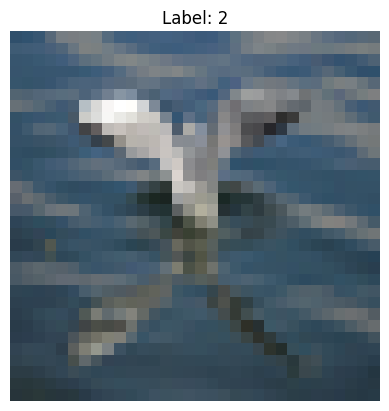

In [ ]:
import matplotlib.pyplot as plt
import torchvision

image = batch['img'][31]
label = batch['label'][31]

image = image*0.5+0.5

plt.imshow(image.permute(1,2,0).numpy())
plt.title(f"Label: {label.item()}")
plt.axis('off')
plt.show()

In [ ]:
for batch in valloader:
  print(batch)
  break

{'img': tensor([[[[-0.2627, -0.1686, -0.2235,  ..., -0.0745, -0.2157, -0.2941],
          [-0.1216, -0.1843, -0.2078,  ..., -0.0118, -0.1059, -0.2235],
          [ 0.0275, -0.2627, -0.2471,  ..., -0.1216, -0.1686, -0.1686],
          ...,
          [ 0.7569,  0.8196,  0.6784,  ...,  0.7569,  0.7569,  0.7647],
          [ 0.6392,  0.7882,  0.6941,  ...,  0.7020,  0.6863,  0.7490],
          [ 0.5843,  0.6471,  0.6627,  ...,  0.6157,  0.6392,  0.7490]],

         [[-0.2549, -0.1451, -0.2000,  ..., -0.0353, -0.1843, -0.2392],
          [-0.1216, -0.2157, -0.2235,  ..., -0.0118, -0.0824, -0.1922],
          [-0.0118, -0.3020, -0.2627,  ..., -0.1451, -0.1451, -0.1608],
          ...,
          [ 0.7098,  0.7882,  0.6078,  ...,  0.6314,  0.6471,  0.6471],
          [ 0.5765,  0.7412,  0.6078,  ...,  0.6157,  0.6157,  0.6706],
          [ 0.5529,  0.6000,  0.5608,  ...,  0.5765,  0.6157,  0.7176]],

         [[-0.5451, -0.4902, -0.5373,  ..., -0.4039, -0.5686, -0.6000],
          [-0.4275, -0

In [ ]:
def count_images(loader):
    total_images = 0
    for batch in loader:
        total_images += len(batch['img'])
    return total_images

train_images = count_images(trainloader)
val_images = count_images(valloader)
test_images = count_images(testloader)
print(f"Total images in trainloader: {train_images}")
print(f"Total images in valloader: {val_images}")
print(f"Total images in testloader: {test_images}")

Total images in trainloader: 4000
Total images in valloader: 1000
Total images in testloader: 10000


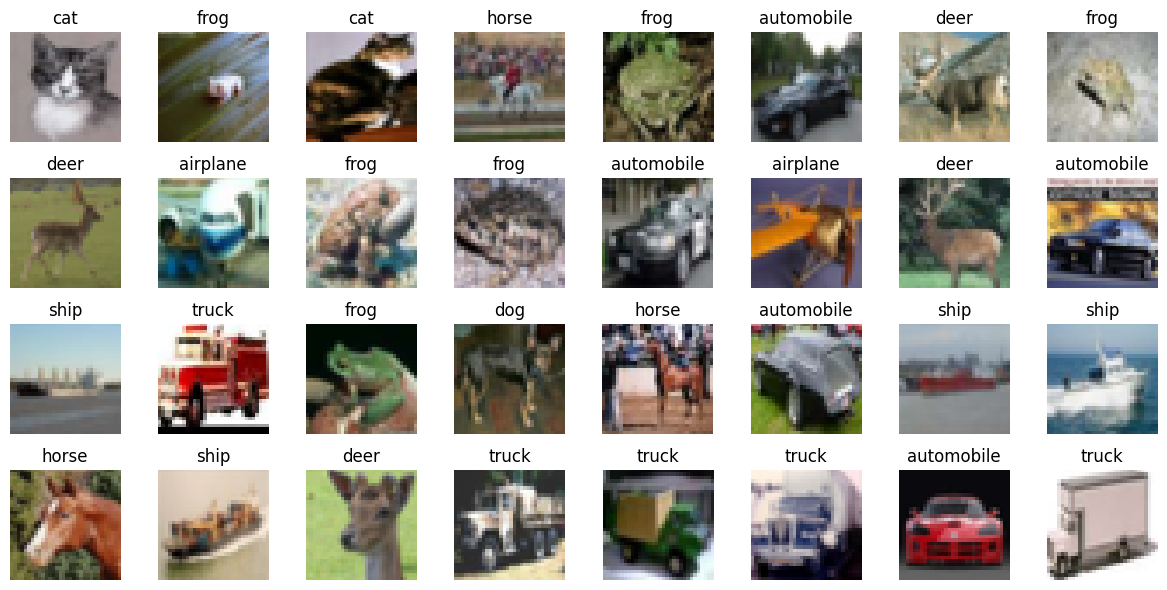

In [ ]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
# iter(trainloader): Converts the trainloader into an iterator which can be used to fetch batches of data one by one.
# next(): Fetches the next batch of data from the iterator.
# batch = next(iter(trainloader)) fetches one batch of data from the trainloader.
images, labels = batch["img"], batch["label"]

images = images.permute(0, 2, 3, 1).numpy() # [Batch, Channels, Height, Width] → [Batch, Height, Width, Channels]
images = images / 2 + 0.5 # denormalise

fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()

In [ ]:
from collections import Counter

NUM_CLIENTS = 10
NUM_CLASSES = 10

total_counts_client_class = np.zeros((NUM_CLASSES, NUM_CLIENTS)) # (10*10)
for client_id in range(NUM_CLIENTS):
    trainloader, _, _ = load_datasets(client_id)
    label_list = []
    for batch in trainloader:
        labels = batch["label"] # 32 sized tensor and converting it into list by labels.tolist() & appending it to label_list
        label_list.extend(labels.tolist())
    class_counts = Counter(label_list)
    # Counter(label_list) is a dictionary to store one client has how many objects of 10 classes
    for cls in range(NUM_CLASSES):
        total_counts_client_class[cls][client_id] = class_counts.get(cls, 0)

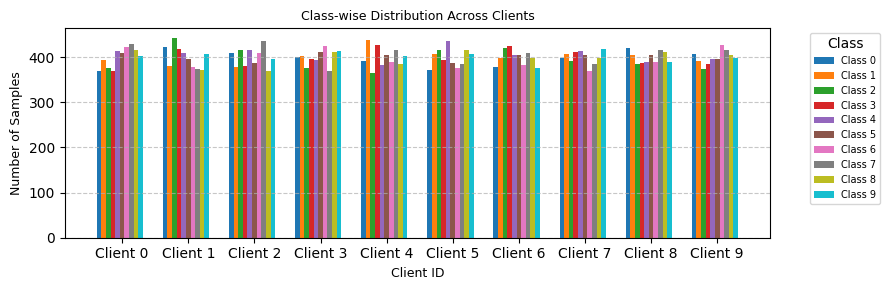

In [ ]:
x=np.arange(NUM_CLIENTS)
bar_width=0.07

plt.figure(figsize=(9,3))

for cls in range(NUM_CLASSES):
    plt.bar(x+cls*bar_width,total_counts_client_class[cls],width=bar_width,label=f'Class {cls}')

plt.xlabel("Client ID", fontsize=9)
plt.ylabel("Number of Samples", fontsize=9)
plt.title("Class-wise Distribution Across Clients", fontsize=9)
plt.xticks(x+bar_width*NUM_CLASSES/2, [f"Client {i}" for i in range(NUM_CLIENTS)])
plt.legend(title="Class",bbox_to_anchor=(1.05,1),loc="upper left",fontsize=7)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()

Define the model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*4*4,512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512,10),
        )

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x